In [1]:
import pandas as pd
import numpy as np
import glob
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import pathlib
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torch.optim.lr_scheduler import ExponentialLR
from torchviz import make_dot

import pytorch_lightning as pl

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
from matplotlib.ticker import MaxNLocator

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

import datetime
import time
import random
import os


# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

/home/lisa/anaconda3/envs/agg_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0

NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
class GRU(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=64, num_layers=2, num_classes=5):
        super(GRU, self).__init__()

        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )

        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # x comes in as (batch, 1, 20, 10)
        # Remove the unnecessary channel dimension
        x = x.squeeze(1)              # shape → (batch, 20, 10)

        out, hidden = self.gru(x)     # GRU accepts (batch, seq_len=20, input_dim=10)

        out = out[:, -1, :]           # last timestep output
        out = self.fc(out)
        return self.softmax(out)

In [3]:
def load_and_concat_csv(path):
    """
    Load all CSV files from a directory and return a single concatenated DataFrame.
    """
    csv_files = glob.glob(os.path.join(path, "*.csv"))

    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in: {path}")

    df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)
    return df

In [4]:
# Tesla Auto Conventional Attack Driving Data
ConAutAtt_Tesla_Normal = load_and_concat_csv("/home/lisa/Arupreza/ADDS/Data/FedModel/ConAttTes/Normal/")
ConAutAtt_Tesla_DoS = load_and_concat_csv("/home/lisa/Arupreza/ADDS/Data/FedModel/ConAutAttTes/DoS/")
ConAutAtt_Tesla_Fuzz = load_and_concat_csv("/home/lisa/Arupreza/ADDS/Data/FedModel/ConAutAttTes/Fuzz/")
ConAutAtt_Tesla_Replay = load_and_concat_csv("/home/lisa/Arupreza/ADDS/Data/FedModel/ConAutAttTes/Replay/")

# Tesla Autonomous Situational Replay Attack Driving Data
SitAutAtt_Tesla_Break = load_and_concat_csv("/home/lisa/Arupreza/ADDS/Data/FedModel/SitAutAttTes/Break/")
SitAutAtt_Tesla_Lane = load_and_concat_csv("/home/lisa/Arupreza/ADDS/Data/FedModel/SitAutAttTes/Lane/")
SitAutAtt_Tesla_Speed = load_and_concat_csv("/home/lisa/Arupreza/ADDS/Data/FedModel/SitAutAttTes/Speed/")

In [5]:
def slice_and_reshape_dataframe(df, lbl, ids, chunk_size=20, overlap=0.5):
    """
    Slice a DataFrame into overlapping chunks of a specified size, apply label encoding and min-max scaling,
    and reshape each chunk for GRU input (20,10).
    """
    cols = ['CAN_ID', 'One', 'Two', 'Three', 'Four', 'Five',
            'Six', 'Seven', 'Eight', 'Time_Delta']
    df = df[cols]
    df = df[df['CAN_ID'].isin(ids)]

    label_encoder = LabelEncoder()
    min_max_scaler = MinMaxScaler()

    df_encoded_scaled = df.apply(label_encoder.fit_transform)
    df_encoded_scaled = pd.DataFrame(
        min_max_scaler.fit_transform(df_encoded_scaled),
        columns=df_encoded_scaled.columns
    )

    step_size = int(chunk_size * (1 - overlap))
    chunk_list = []

    for start in range(0, len(df_encoded_scaled) - chunk_size + 1, step_size):
        chunk = df_encoded_scaled.iloc[start:start + chunk_size]
        # GRU reshape → (20, 10)
        chunk_reshaped = chunk.values.reshape(chunk_size, 10)
        chunk_list.append([chunk_reshaped, lbl])

    # Optional last chunk
    if len(df_encoded_scaled) % step_size != 0:
        last_chunk_start = len(df_encoded_scaled) - chunk_size
        last_chunk = df_encoded_scaled.iloc[last_chunk_start:]
        if len(last_chunk) == chunk_size:
            last_chunk_reshaped = last_chunk.values.reshape(chunk_size, 10)
            chunk_list.append([last_chunk_reshaped, lbl])

    return chunk_list

In [6]:
tesla_id = ['0031', '039D', '0257', '0118', '0108', '0389']

Tesla = []
chunk_size = 20

AF = slice_and_reshape_dataframe(
    df=ConAutAtt_Tesla_Normal,
    lbl='0',
    ids=tesla_id,
    chunk_size=chunk_size
)

Tesla.extend(AF)

DoS = slice_and_reshape_dataframe(
    df=ConAutAtt_Tesla_DoS,
    lbl='1',
    ids=tesla_id,
    chunk_size=chunk_size
)

Tesla.extend(DoS)

Fuzz = slice_and_reshape_dataframe(
    df=ConAutAtt_Tesla_Fuzz,
    lbl='2',
    ids=tesla_id,
    chunk_size=chunk_size
)

Tesla.extend(Fuzz)

Replay = slice_and_reshape_dataframe(
    df=ConAutAtt_Tesla_Replay,
    lbl='3',
    ids=tesla_id,
    chunk_size=chunk_size
)

Tesla.extend(Replay)

Sit_Att_Break = slice_and_reshape_dataframe(
    df=SitAutAtt_Tesla_Break,
    lbl='4',
    ids=tesla_id,
    chunk_size=chunk_size
)

Tesla.extend(Sit_Att_Break)

Sit_Att_Lane = slice_and_reshape_dataframe(
    df=SitAutAtt_Tesla_Lane,
    lbl='5',
    ids=tesla_id,
    chunk_size=chunk_size
)

Tesla.extend(Sit_Att_Lane)

Sit_Att_Speed = slice_and_reshape_dataframe(
    df=SitAutAtt_Tesla_Speed,
    lbl='6',
    ids=tesla_id,
    chunk_size=chunk_size
)

Tesla.extend(Sit_Att_Speed)

X_train, X_test = train_test_split(Tesla, test_size=0.2, random_state=42)

In [7]:
def prepare_data(chunk_list, label_mapping, batch_size=64, shuffle=False):
    # Extract features and labels from chunk_list
    X = [chunk[0] for chunk in chunk_list]  # Features
    y = [chunk[1] for chunk in chunk_list]  # Labels

    # Convert features to PyTorch tensor
    X_tensor = torch.tensor(X, dtype=torch.float32)

    # Convert string labels to numerical labels
    y_numerical = [label_mapping[label] for label in y]
    y_tensor = torch.tensor(y_numerical, dtype=torch.long)

    # Create dataset and data loader
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader

In [8]:
label_mapping = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}  # Define the mapping from string labels to numerical labels

# Prepare data using the function
train_loader = prepare_data(X_train, label_mapping)
test_loader = prepare_data(X_test, label_mapping)

/tmp/ipykernel_9649/197299.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  X_tensor = torch.tensor(X, dtype=torch.float32)


In [9]:
model = GRU(num_classes=10)

# Define the loss function (e.g., cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Choose an optimizer (e.g., Adam optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GRU(
  (gru): GRU(10, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [10]:
# Initialize variables for early stopping
best_val_loss = np.Inf
patience = 10
counter = 0
num_epochs = 50

model.to(device)

train_dataset_len = len(train_loader.dataset)
test_dataset_len = len(test_loader.dataset)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # -------------------------------
    # TRAINING
    # -------------------------------
    for inputs, labels in train_loader:

        # FIX: convert to float + move to device
        inputs = inputs.float().to(device)    # (batch, 20, 10)
        labels = labels.long().to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / train_dataset_len

    # -------------------------------
    # VALIDATION
    # -------------------------------
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for val_inputs, val_labels in test_loader:

            # FIX: convert to float + move to device
            val_inputs = val_inputs.float().to(device)
            val_labels = val_labels.long().to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            running_val_loss += val_loss.item() * val_inputs.size(0)

            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

    epoch_val_loss = running_val_loss / test_dataset_len
    val_accuracy = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {epoch_train_loss:.4f}, "
        f"Val Loss: {epoch_val_loss:.4f}, "
        f"Val Accuracy: {val_accuracy:.2%}")

    # -------------------------------
    # EARLY STOPPING & SAVE
    # -------------------------------
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        counter = 0
        torch.save(model.state_dict(), "Tesla_Auto_GRU_20_Over_50.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/50] Train Loss: 0.6482, Val Loss: 0.2608, Val Accuracy: 89.38%
Epoch [2/50] Train Loss: 0.1941, Val Loss: 0.1290, Val Accuracy: 95.70%
Epoch [3/50] Train Loss: 0.1201, Val Loss: 0.0893, Val Accuracy: 96.20%
Epoch [4/50] Train Loss: 0.0969, Val Loss: 0.0710, Val Accuracy: 97.46%
Epoch [5/50] Train Loss: 0.0850, Val Loss: 0.0599, Val Accuracy: 97.56%
Epoch [6/50] Train Loss: 0.0744, Val Loss: 0.1436, Val Accuracy: 95.07%
Epoch [7/50] Train Loss: 0.0739, Val Loss: 0.0603, Val Accuracy: 97.73%
Epoch [8/50] Train Loss: 0.0601, Val Loss: 0.0610, Val Accuracy: 97.40%
Epoch [9/50] Train Loss: 0.0585, Val Loss: 0.0612, Val Accuracy: 97.46%
Epoch [10/50] Train Loss: 0.0617, Val Loss: 0.0561, Val Accuracy: 97.61%
Epoch [11/50] Train Loss: 0.0500, Val Loss: 0.0455, Val Accuracy: 98.43%
Epoch [12/50] Train Loss: 0.0477, Val Loss: 0.0413, Val Accuracy: 98.38%
Epoch [13/50] Train Loss: 0.0439, Val Loss: 0.0659, Val Accuracy: 97.82%
Epoch [14/50] Train Loss: 0.0444, Val Loss: 0.0482, Val Accu

In [11]:
def get_prediction(model, dataloader):
    with torch.no_grad():
        model = model.to(device)
        model.eval()
        prediction = np.zeros(len(dataloader.dataset))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if device:
                images = images.type(torch.cuda.FloatTensor)
            prediction[k:k+len(images)] = np.argmax(model(images).data.cpu().numpy(), axis=1)
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return prediction, labels

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# --- Updated class labels --- #
class_labels = ["S&AF", "DoS", "Fuzz", "Replay", "AAB", "AAL", "AAA"]

# --- SAME colormap used in upper 10-class confusion matrix --- #
light_greeyellow = LinearSegmentedColormap.from_list(
    "light_greenyellow",
    ["#FFFFFF", "#F5FFB0", "#DAFF70"]   # white → light → medium-light greenyellow
)

def plot_confusion_matrix(cf_matrix, class_labels):
    cf_matrix = np.array(cf_matrix)
    n = len(class_labels)

    # ---- Calculate row percentages ---- #
    percentages = np.zeros_like(cf_matrix, dtype=float)
    for i in range(n):
        row_sum = cf_matrix[i].sum()
        if row_sum > 0:
            percentages[i] = (cf_matrix[i] / row_sum) * 100

    # ---- Normalize for heat intensity ---- #
    intensity_matrix = percentages / 100.0

    # ---- Plot heatmap ---- #
    plt.figure(figsize=(14, 12))
    ax = sns.heatmap(
        intensity_matrix,
        cmap=light_greeyellow,
        cbar=False,
        annot=False,
        linewidths=1.0,
        linecolor="black"
    )

    # ---- Overlay numbers + percentages ---- #
    for i in range(n):
        for j in range(n):
            ax.text(
                j + 0.5, i + 0.33,
                f"{cf_matrix[i][j]}",
                ha="center", va="center",
                fontsize=18, fontweight="bold", color="black"
            )
            ax.text(
                j + 0.5, i + 0.74,
                f"{percentages[i][j]:.2f}%",
                ha="center", va="center",
                fontsize=15, fontweight="bold", color="black"
            )

    # ---- Tick colors (updated to match new class labels) ---- #
    tick_colors = {
        "S&AF": "green",
        "DoS": "#800000", "Fuzz": "#800000", "Replay": "#800000",
        "AAB": "red", "AAL": "red", "AAA": "red"
    }

    ax.set_xticks(np.arange(n) + 0.5)
    ax.set_yticks(np.arange(n) + 0.5)

    ax.set_xticklabels(
        class_labels, rotation=45, ha='right',
        fontsize=18, fontweight="bold"
    )
    ax.set_yticklabels(
        class_labels, rotation=0,
        fontsize=18, fontweight="bold"
    )

    # Apply tick colors
    for idx, lbl in enumerate(class_labels):
        ax.get_xticklabels()[idx].set_color(tick_colors[lbl])
        ax.get_yticklabels()[idx].set_color(tick_colors[lbl])

    # ---- Axis labels ---- #
    plt.xlabel("True Labels", fontsize=22, fontweight="bold", color="darkblue")
    plt.ylabel("Predicted Labels", fontsize=22, fontweight="bold", color="darkblue")

    plt.tight_layout()
    plt.show()


In [20]:
pred = get_prediction(model, test_loader)
y_pred = pred[0]
y_test = pred[1]

In [21]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[1433    0    0    0    0    0    0]
 [   0  530    0    2    0    0    0]
 [   0    0  524    0    0    0    0]
 [   0   68    1  532    0    0    0]
 [   0    0    0    0  594    0   31]
 [   0    0    0    0    0  359    0]
 [   0    1    1    1    2    2  682]]


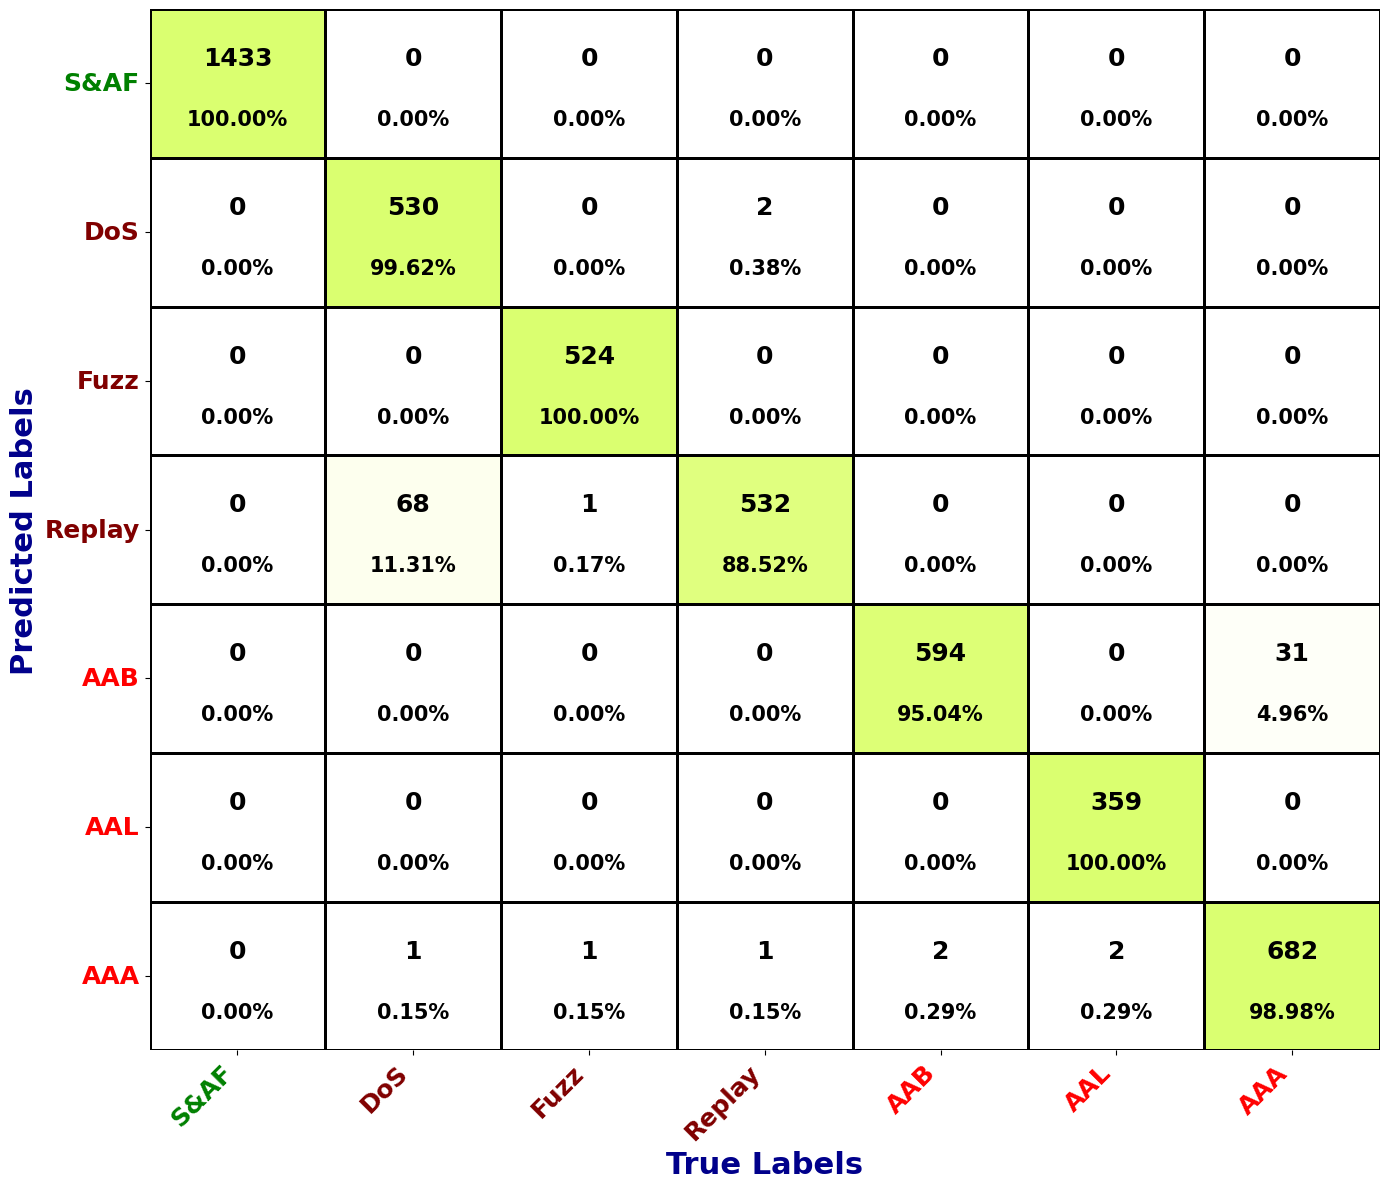

In [22]:
plot_confusion_matrix(cf_matrix, class_labels)

In [16]:
import numpy as np
import pandas as pd
from math import sqrt
from scipy.stats import norm
from sklearn.metrics import roc_auc_score

def compute_full_metrics(cf_matrix, class_labels, confidence=0.95):
    """
    Computes:
    - Precision
    - Recall
    - F1-score
    - Accuracy
    - Error rate
    - 95% CI
    - AUC per class (One-vs-Rest)

    Works purely from a confusion matrix.
    """
    cf = np.array(cf_matrix)
    n_classes = len(class_labels)

    # Prepare result table
    results = {
        "Class": [],
        "Support": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "Accuracy": [],
        "Error_Rate": [],
        "CI_Lower": [],
        "CI_Upper": [],
        "AUC": []
    }

    # Z-score for confidence interval
    z = norm.ppf(1 - (1 - confidence) / 2)

    # ---- Compute Per-Class Metrics ---- #
    for i in range(n_classes):

        TP = cf[i, i]
        FN = np.sum(cf[i, :]) - TP
        FP = np.sum(cf[:, i]) - TP
        TN = np.sum(cf) - (TP + FP + FN)

        support = TP + FN

        # Precision, recall, F1
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1        = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Accuracy & error rate
        accuracy = TP / support if support > 0 else 0
        error_rate = 1 - accuracy

        # ---- Wilson Confidence Interval ---- #
        if support > 0:
            phat = accuracy
            denom = 1 + z*z/support
            centre = phat + z*z/(2*support)
            margin = z * sqrt((phat*(1-phat) + z*z/(4*support)) / support)

            CI_lower = (centre - margin) / denom
            CI_upper = (centre + margin) / denom
        else:
            CI_lower = CI_upper = 0

        # ---- AUC (One-vs-Rest) ---- #
        # Build binary GT and prediction scores
        y_true = np.repeat(np.arange(n_classes), cf.sum(axis=1))
        y_score = np.zeros_like(y_true, dtype=float)

        # Score = proportion of predicted class for this row
        counter = 0
        for r in range(n_classes):
            for _ in range(cf[r].sum()):
                y_score[counter] = cf[r][i] / cf[r].sum() if cf[r].sum() > 0 else 0
                counter += 1

        y_bin = (y_true == i).astype(int)

        try:
            auc = roc_auc_score(y_bin, y_score)
        except:
            auc = np.nan

        # ---- Store ---- #
        results["Class"].append(class_labels[i])
        results["Support"].append(int(support))
        results["Precision"].append(round(precision, 4))
        results["Recall"].append(round(recall, 4))
        results["F1"].append(round(f1, 4))
        results["Accuracy"].append(round(accuracy, 4))
        results["Error_Rate"].append(round(error_rate, 4))
        results["CI_Lower"].append(round(CI_lower, 4))
        results["CI_Upper"].append(round(CI_upper, 4))
        results["AUC"].append(round(auc, 4) if auc == auc else None)

    return pd.DataFrame(results)

In [17]:
stats_df = compute_full_metrics(cf_matrix, class_labels)

In [18]:
stats_df

,Class,Support,Precision,Recall,F1,Accuracy,Error_Rate,CI_Lower,CI_Upper,AUC
0,S&AF,1433,1.0000,1.0000,1.0000,1.0000,0.0000,0.9973,1.0000,1.0
1,D,532,0.8848,0.9962,0.9372,0.9962,0.0038,0.9864,0.9990,1.0
2,F,524,0.9962,1.0000,0.9981,1.0000,0.0000,0.9927,1.0000,1.0
3,R,601,0.9944,0.8852,0.9366,0.8852,0.1148,0.8572,0.9083,1.0
4,AAB,625,0.9966,0.9504,0.9730,0.9504,0.0496,0.9305,0.9648,1.0
5,AAL,359,0.9945,1.0000,0.9972,1.0000,0.0000,0.9894,1.0000,1.0
6,AAA,689,0.9565,0.9898,0.9729,0.9898,0.0102,0.9792,0.9951,1.0
